In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import fcwt
%matplotlib inline

### Import and process KPLO Data

In [2]:

"Load KMAG Data"
kmag1 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230115_GSE_1sec.csv')
kmag2 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230116_GSE_1sec.csv')
kmag3 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\KPLO\KPLO_KMAG_230117_GSE_1sec.csv')
kmag = pd.concat([kmag1, kmag2, kmag3])

"Load THEMIS Data"
themis1 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230115_themis_thb_fgm_fgs_l2.csv')
themis2 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230116_themis_thb_fgm_fgs_l2.csv')
themis3 = pd.read_csv(r'c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\utility\SPACE_DATA\THEMIS\20230117_themis_thb_fgm_fgs_l2.csv')
themis = pd.concat([themis1, themis2, themis3])
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th = np.vstack((Bx_th, By_th, Bz_th))
themis_t = pd.to_datetime(themis['UTC']).to_numpy()

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z));
B_2b = np.vstack((B2_x, B2_y, B2_z)); 
B_1b = np.vstack((B1_x, B1_y, B1_z)); 
B = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
t = pd.to_datetime(kmag['UTC']).to_numpy()

In [3]:
"Find gaps"
B = B[:,:,100:-100]; t = t[100:-100]
gaps = 1- np.isnan(B[0,0])
g = 1 - np.isnan(B[0,0])
print(np.sum(1-gaps))

1753


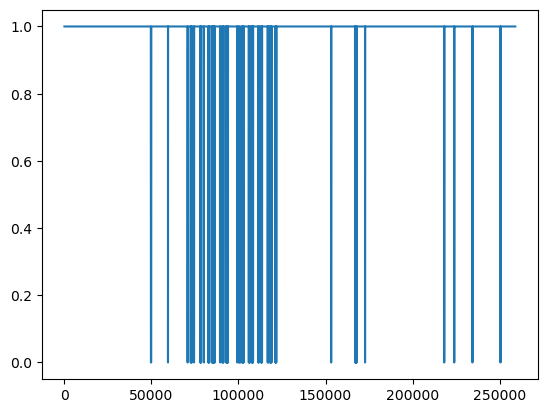

In [4]:
plt.plot(g)

### Interpolate the data


In [5]:
from magprime.utility import interpolation
interpolation.mssa.n_components = "parallel_analysis"
interpolation.mssa.pa_percentile_threshold = 5
interpolation.mssa.verbose = False
print(B.shape)
B_interpolated_x = interpolation.mssa.interpolate(np.copy(B[:,0]), np.copy(gaps), triaxial=False)
B_interpolated_y = interpolation.mssa.interpolate(np.copy(B[:,1]), np.copy(gaps), triaxial=False)
B_interpolated_z = interpolation.mssa.interpolate(np.copy(B[:,2]), np.copy(gaps), triaxial=False)


c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(3, 3, 259000)


  0%|          | 0/71 [00:00<?, ?it/s]c:\Users\alexp\anaconda3\lib\site-packages\pymssa\optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  components = _incremental_component_reconstruction_inner(
c:\Users\alexp\anaconda3\lib\site-packages\pymssa\optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  components = _incremental_component_reconstruction_inner(
100%|██████████| 71/71 [08:33<00:00,  7.23s/it] 


In [6]:
B_interpolated = np.stack((B_interpolated_x, B_interpolated_y, B_interpolated_z), axis=1)

In [7]:
import numpy as np
from wavelets import WaveletAnalysis

def inverse_wavelet_transform(filtered_w, w):
    # w: (n_scales, n_sensors, n_axes, n_samples)
    _, n_sensors, n_axes, n_samples = filtered_w.shape
    result  = np.zeros((n_sensors, n_axes, n_samples))

    for i in range(n_axes):
        for j in range(n_sensors):
                W_n = filtered_w[:,j,i,:] 
                Y_00 = w.wavelet.time(0)
                r_sum = np.sum(W_n.real.T / w.scales ** .5, axis=-1).T
                amb_mf = r_sum * (w.dj * w.dt ** .5 / (w.C_d * Y_00))
                result[j,i,:] = np.real(amb_mf)

    return result


# Define the filterSSP function for identifying multi-source points (MSPs)
def identify_MSP(B, sspTol=15):
    """Identify Multi Source Points"""
    a = np.real(B)
    b = np.imag(B)
    a_dot_b = (a * b).sum(axis=0)
    norm_a = np.linalg.norm(a, axis=0)
    norm_a[norm_a == 0] = 1
    norm_b = np.linalg.norm(b, axis=0)
    norm_b[norm_b == 0] = 1
    cos_sim = np.abs(a_dot_b / (norm_a * norm_b))
    MSP_Bools = cos_sim < np.cos(np.deg2rad(sspTol))
    return MSP_Bools

# Define the identifyASSP function for identifying ambient single-source points (ambient SSPs)
def identify_ASSP(data, sspTol=15):
    """Identify Ambient Single Source Points"""
    a = np.abs(data)
    b = np.ones(data.shape)
    a_dot_b = (a * b).sum(axis=0)
    norm_a = np.linalg.norm(a, axis=0)
    norm_a[norm_a == 0] = 1
    norm_b = np.linalg.norm(b, axis=0)
    norm_b[norm_b == 0] = 1
    cos_sim = np.abs(a_dot_b / (norm_a * norm_b))
    ASSP_Bools = cos_sim >= np.cos(np.deg2rad(sspTol))
    return ASSP_Bools


def filter_wavelets(w, sspTol=15):
    n_scales, n_sensors, n_axes, n_samples = w.shape
    
    # Flatten scales
    w_flattened = w.transpose(1, 2, 0, 3).reshape(n_sensors, n_axes, n_scales * n_samples)
    
    for i in range(n_axes):        
        # Identify MSPs and zero them out
        MSP_Bools = identify_MSP(w_flattened[:, i, :], sspTol=sspTol)
        w_flattened[:, i, MSP_Bools] = 0
        
        # Identify ambient SSPs and zero them out
        ASSP_Bools = identify_ASSP(w_flattened[:, i, :], sspTol=sspTol)
        w_flattened[:, i, ASSP_Bools] = 0
    
    # Reshape back to original dimensions
    filtered_w = w_flattened.reshape(n_sensors, n_axes, n_scales, n_samples).transpose(2, 0, 1, 3)
    
    return filtered_w



In [7]:
"Calculate Coupling Coefficients"
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
aii = calculate_coupling_coefficients(B_interpolated, fs = 1, sspTol=20)

c:\Users\alexp\anaconda3\lib\site-packages\magprime\utility\coupling_coefficients.py:28: RuntimeWarning: invalid value encountered in divide
  alpha_couplings = np.nanmean((np.abs(B_filtered[0]) / np.abs(B_filtered[1])), axis=-1)


In [39]:
print(aii)

[7.47853459 4.31977126 6.22436556]


1326


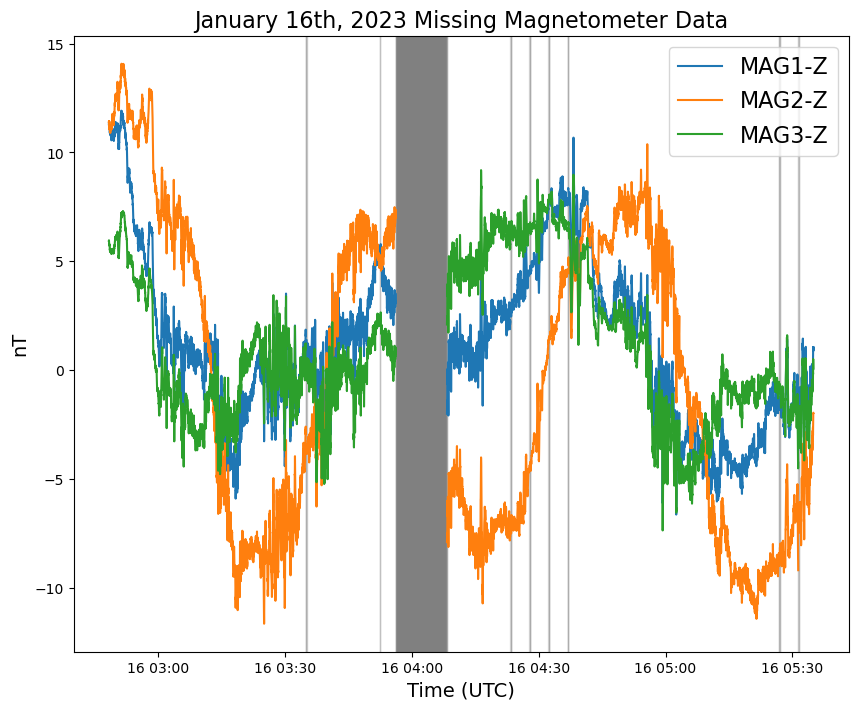

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Missing Magnetometer Data", fontsize=16)
axs.plot(t[10000:20000], B[:,2,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])

plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000:20000] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='grey', alpha=0.1)

print(np.sum(g == 0))

In [23]:

def find_gaps(gaps):
    # Find Gap starting and ending indices
    gap_indices = np.where(gaps == 0)[0]
    if gap_indices.size == 0:
        return []  # No gaps to fill

    gap_starts = np.hstack(([0], np.where(np.diff(gap_indices) != 1)[0] + 1))
    gap_ends = np.hstack((np.where(np.diff(gap_indices) != 1)[0], [len(gap_indices) - 1]))
    full_gaps = [(gap_indices[start], gap_indices[end]) for start, end in zip(gap_starts, gap_ends)]

    # Create a list to store gap info with window analysis
    gap_info = []

    for start, end in full_gaps:
        gap_length = end - start + 1
        window_radius = 2 * gap_length
        window_start = max(0, start - window_radius)
        window_end = min(len(gaps) - 1, end + window_radius)

        # Count valid data points in the window
        window_data_count = np.sum(gaps[window_start:start]) + np.sum(gaps[end + 1:window_end + 1])

        gap_info.append((start, end, gap_length, int(window_data_count//gap_length > 3)))

    # Rank gaps - example by smallest gap first, then by maximum surrounding data
    gap_info.sort(key=lambda x: (-x[3],x[2]))
    return(gap_info)

gap_info = find_gaps(g)
print(gap_info[-10:])

[(32266, 32275, 10, 1), (32536, 32545, 10, 1), (19512, 19522, 11, 1), (81391, 81427, 37, 1), (80746, 80801, 56, 1), (80962, 81017, 56, 1), (80523, 80581, 59, 1), (81171, 81180, 10, 0), (81182, 81238, 57, 0), (14070, 14797, 728, 0)]


### Plot Interpolated data

In [18]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = True # Detrend the data
WAICUP.uf = 8640*2 # Number of points in uniform filter (uf)
WAICUP.aii = np.array([ 7.01002316, 75.24653706,  6.26681301]) # Coupling Coefficients

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(B_interpolated[1:]), triaxial=True)

c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


NameError: name 'gap_indices' is not defined

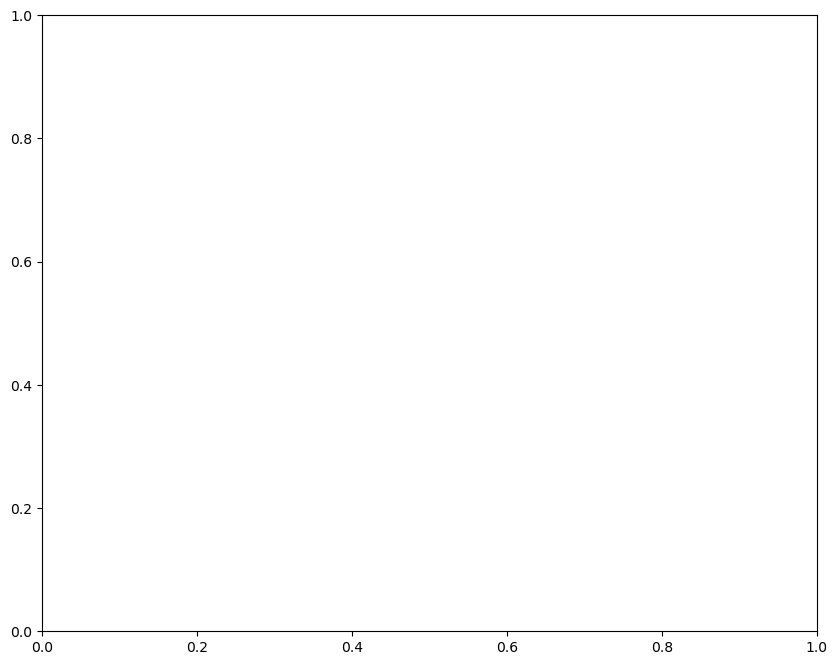

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
#th_start = 2276; th_end = 4603
for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='lightgrey', alpha=0.1)

#axs.plot(t[10000:20000], B_interpolated[:,2,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
#axs.plot(t[10000:20000], B_WAICUP[2,10000:20000], label="WAIC-UP Z")
axs.plot(B_WAICUP.T)
#axs.plot(themis_t[th_start:th_end], B_th[2,th_start:th_end], label="THEMIS-Z")
axs.legend(loc=1, fontsize=16)

IndexError: index 90523 is out of bounds for axis 0 with size 86200

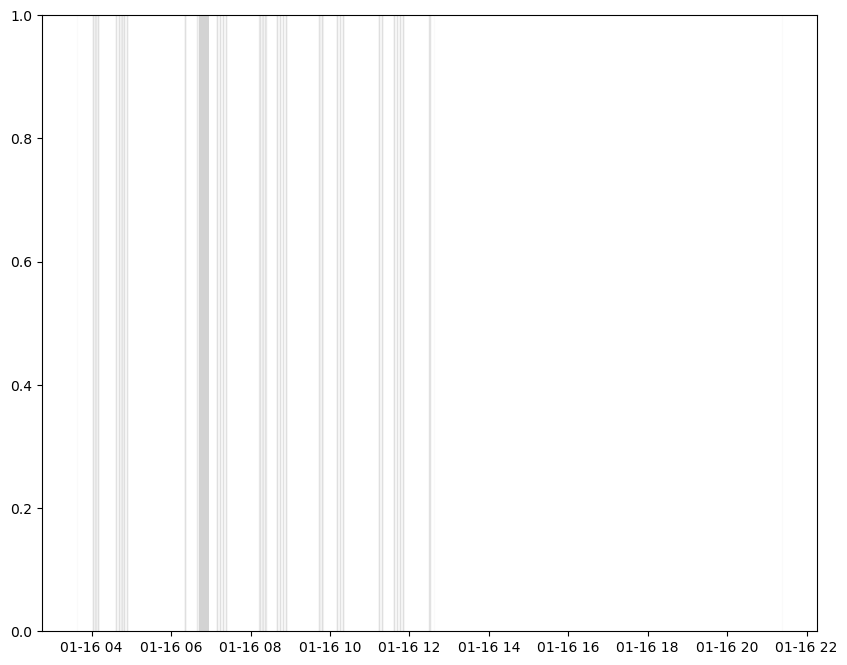

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
th_start = 2276; th_end = 4603
for idx in gap_indices:
    axs.axvspan(t[10000 + idx], t[10000 + idx + 1], color='lightgrey', alpha=0.1)

#axs.plot(t[10000:20000], B_interpolated[:,0,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
axs.plot(t[10000:20000], B_WAICUP[1,10000:20000], label="WAIC-UP Z")
axs.plot(themis_t[th_start:th_end], B_th[1,th_start:th_end], label="THEMIS-Z")
axs.legend(loc=1, fontsize=16)

In [38]:

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
gap_indices = np.where(g == 0)[0]
for idx in gap_indices:
    axs.axvspan(t[0 + idx], t[0 + idx + 1], color='lightgrey', alpha=0.1)

#axs.plot(t[10000:20000], B_interpolated[:,0,10000:20000].T, label=["MAG1-Z", "MAG2-Z", "MAG3-Z"])
axs.plot(t, B_WAICUP[1])
axs.plot(themis_t, B_th[1], label="THEMIS-Z")


In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
th_start = 2276; th_end = 4603
gap_indices = np.where(g == 0)[0]
for idx in gap_indices:
    axs.axvspan(t[0 + idx], t[0 + idx + 1], color='lightgrey', alpha=0.1)

axs.plot(t, B_interpolated[2,2], label=["MAG2-Z"])
axs.plot(t, B_WAICUP[1], label="WAIC-UP Y")
axs.plot(themis_t, B_th[1], label="THEMIS-Y")
axs.legend(loc=1, fontsize=16)
axs.set_title("Y-axis", fontsize=16)

Text(0.5, 1.0, 'Y-axis')

In [25]:
print(t[106400], themis_t[4603+20160])

2023-01-16T05:35:00.000000000 2023-01-16T05:35:00.000000000


1753


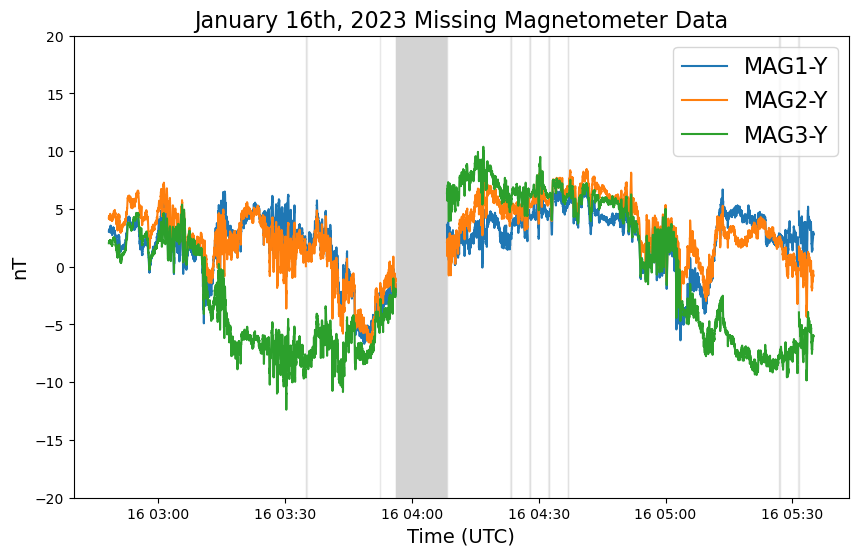

In [45]:
t_start = 86400
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Missing Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B[:,1,10000+t_start:20000+t_start].T, label=["MAG1-Y", "MAG2-Y", "MAG3-Y"])
axs.set_ylim(-20, 20)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)

print(np.sum(g == 0))

1753


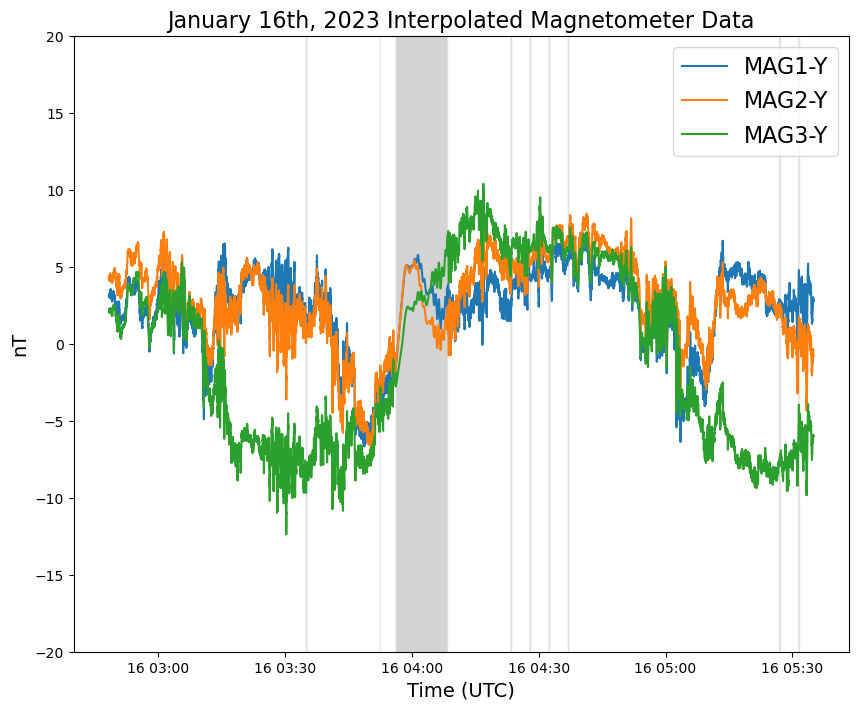

In [20]:
t_start = 86400
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True, sharey=True)
axs.set_title("January 16th, 2023 Interpolated Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B_interpolated[:,1,10000+t_start:20000+t_start].T, label=["MAG1-Y", "MAG2-Y", "MAG3-Y"])
axs.set_ylim(-20, 20)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("nT", fontsize=14)
plt.legend(loc=1, fontsize=16)

gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]

for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)

print(np.sum(g == 0))

Text(0.5, 0, 'Time (UTC)')

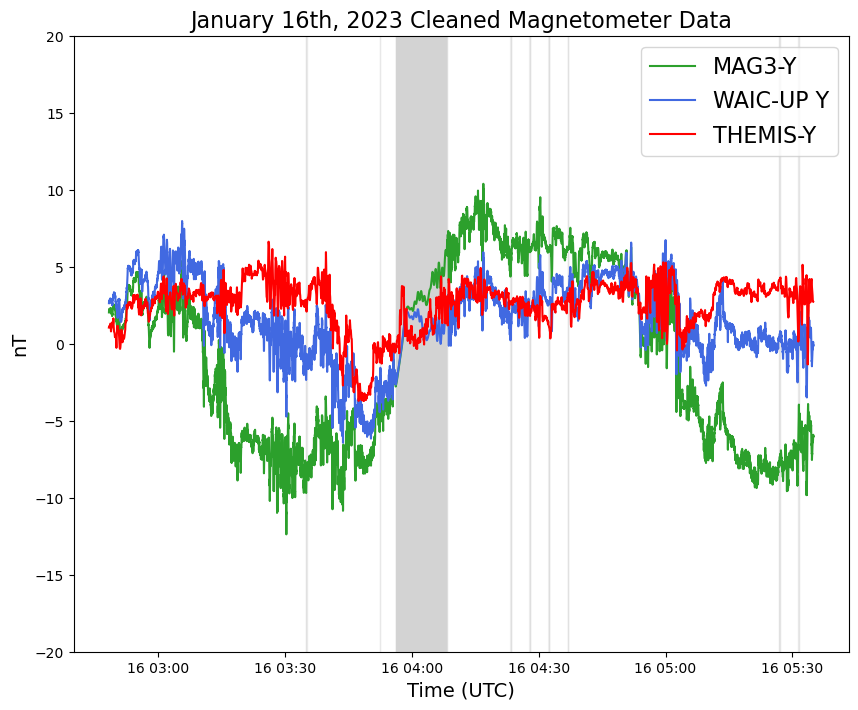

In [21]:
"Cleaned Magnetometer Data"
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
t_start = 86400
th_start = 2276+20160; th_end = 4603+20160
gap_indices = np.where(g[10000+t_start:20000+t_start] == 0)[0]
axs.set_ylim(-20, 20)
for idx in gap_indices:
    axs.axvspan(t[10000+t_start + idx], t[10000+t_start + idx + 1], color='lightgrey', alpha=0.1)
axs.set_title("January 16th, 2023 Cleaned Magnetometer Data", fontsize=16)
axs.plot(t[10000+t_start:20000+t_start], B_interpolated[2,1,10000+t_start:20000+t_start].T, label="MAG3-Y", color='#2ca02c')
axs.plot(t[10000+t_start:20000+t_start], B_WAICUP[1,10000+t_start:20000+t_start], label="WAIC-UP Y", color = 'royalblue')
axs.plot(themis_t[th_start:th_end], B_th[1,th_start:th_end], label="THEMIS-Y", color = 'red')
axs.legend(loc=1, fontsize=16)
axs.set_ylabel("nT", fontsize=14)
axs.set_xlabel("Time (UTC)", fontsize=14)
